In [1]:
"""
This is online lira
"""

import numpy as np
from pathlib import Path

#import torch
from unlearning.auditors.utils import (
    loader_factory,
)
#ULIRA_BASE_DIR = Path("/n/home04/rrinberg/data_dir__holylabs/unlearning/precomputed_models/ULIRA/")
ULIRA_BASE_DIR = Path("/n/home04/rrinberg/data_dir__holylabs/unlearning/precomputed_models/ULIRA_clean")


def get_ulira_training_masks(dataset_name):
    masks_path = ULIRA_BASE_DIR / "training_masks.npy"
    masks = np.load(masks_path)
    return masks

ds_name = "CIFAR10"
training_masks = get_ulira_training_masks(ds_name)

/n/holylabs/LABS/vadhan_lab/Lab/rrinberg/envs/unlearning_3.10/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


No augmentation


100%|██████████| 170498071/170498071 [00:27<00:00, 6233182.54it/s]


Extracting /tmp/cifar_for_unlearning/cifar-10-python.tar.gz to /tmp/cifar_for_unlearning/


(array([2., 3., 6., 9., 5., 7., 4., 8., 3., 3.]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <BarContainer object of 10 artists>)

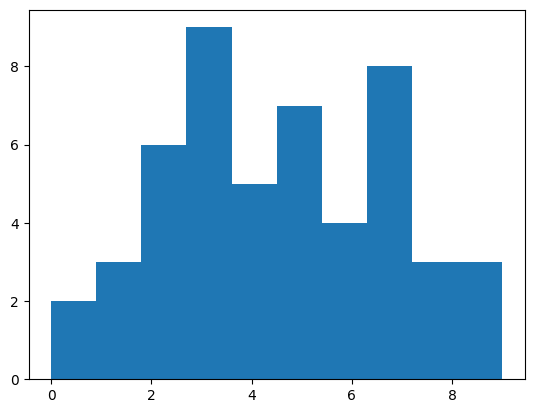

In [2]:
numbers = [
    314, 821, 1030, 1900, 2354, 2729, 3104, 4070, 4086, 4144, 4817, 5395, 6017,
    6230, 6715, 6748, 8883, 10557, 12007, 12609, 12969, 12995, 13356, 13624,
    14170, 14487, 16286, 24148, 26158, 26497, 27578, 27802, 29112, 30188,
    31755, 36585, 38172, 38340, 41252, 42501, 42745, 43044, 43106, 43136,
    44076, 44233, 47149, 47522, 49545, 49936
]
# get labels for these numbers
train_loader = loader_factory("CIFAR10", indexed=True)
train_targets = np.array(train_loader.dataset.original_dataset.targets)
labels = train_targets[numbers]
from matplotlib import pyplot as plt
plt.hist(labels, bins=10)

In [3]:
def generate_one_ulira_forget_mask(train_targets,
                                   training_mask,
                                   SEED=42,
                                   unlearning_forget_set_count=40,
                                   unlearning_forget_set_size=200,
                                   only_class_5=True,
                                   class_5_range=1_000):
    """
    class_5_range is the number of points from class 5 we want to consider forgetting
    """

    np.random.seed(SEED)
    N = len(train_targets)

    if only_class_5:
        class_5_mask = (train_targets == 5)
    else:
        print(f"sample from all classes!")
        class_5_mask = np.ones(N, dtype=bool)

    class_5_indices = class_5_mask.nonzero()[0]
    # pick 1000 points from class 5
    class_5_indices = np.random.choice(class_5_indices,
                                       class_5_range,
                                       replace=False)
    class_5_mask = np.zeros(N)
    class_5_mask[class_5_indices] = 1
    ####
    ulira_forget_mask = []

    indiv_training_mask_ = training_mask

    for _ in range(unlearning_forget_set_count):

        train_and_5 = np.array(indiv_training_mask_ * class_5_mask, dtype=bool)

        class_5_trained_on_mask = np.array(train_and_5)
        class_5_trained_on_indices = class_5_trained_on_mask.nonzero()[0]
        indices = np.random.choice(class_5_trained_on_indices,
                                   unlearning_forget_set_size,
                                   replace=False)
        mask = np.zeros(N)
        mask[indices] = 1
        ulira_forget_mask.append(mask)

    return np.array(ulira_forget_mask)


def get_ulira_forget_masks(dataset_name, original_model_count = 256, class_5_range=1000, unlearnings_per_model = 40,unlearning_forget_set_size=50, overwrite = False ,only_class_5=True):
    training_mask = get_ulira_training_masks(dataset_name)
    ulira_forget_mask_dir = ULIRA_BASE_DIR / f"forget__{unlearning_forget_set_size}"
    # make dir
    ulira_forget_mask_dir.mkdir(exist_ok=True)

    train_loader = loader_factory(dataset_name, indexed=True)
    train_targets = np.array(train_loader.dataset.original_dataset.targets)


    ulira_forget_masks = []
    for model_i in range(original_model_count):

        path = ulira_forget_mask_dir / f"forget_masks__{model_i}.npy"
        if path.exists() and not overwrite:
            # load it
            print(f"loading {path}")
            ulira_forget_mask = np.load(path)
            print(f"ulira_forget_mask.shape {ulira_forget_mask.shape}")
            ulira_forget_masks.append(ulira_forget_mask)

        else:
            training_mask = training_masks[model_i]
            ulira_forget_mask = generate_one_ulira_forget_mask(train_targets, training_mask, class_5_range=class_5_range, unlearning_forget_set_count=unlearnings_per_model, unlearning_forget_set_size=unlearning_forget_set_size, only_class_5=only_class_5)
            # save it
            np.save(path, ulira_forget_mask)
            ulira_forget_masks.append(ulira_forget_mask)
        if model_i % 50 == 0:
            print(f"{model_i} / {original_model_count}")
            #priunt shape
            print(ulira_forget_mask.shape)
    return ulira_forget_masks


unlearning_forget_set_size = 50
#unlearning_forget_set_size = 25
unlearning_forget_set_size = 200

#ulira_forget_masks = get_ulira_forget_masks(ds_name, class_5_range=1000)
ulira_forget_masks = get_ulira_forget_masks(ds_name, class_5_range=500, unlearning_forget_set_size= unlearning_forget_set_size, only_class_5=False)
ulira_forget_masks = get_ulira_forget_masks(ds_name, class_5_range=1000, unlearning_forget_set_size= unlearning_forget_set_size, only_class_5=True)

No augmentation
Files already downloaded and verified
loading /n/home04/rrinberg/data_dir__holylabs/unlearning/precomputed_models/ULIRA_clean/forget__200/forget_masks__0.npy
ulira_forget_mask.shape (40, 50000)
0 / 256
(40, 50000)
loading /n/home04/rrinberg/data_dir__holylabs/unlearning/precomputed_models/ULIRA_clean/forget__200/forget_masks__1.npy
ulira_forget_mask.shape (40, 50000)
loading /n/home04/rrinberg/data_dir__holylabs/unlearning/precomputed_models/ULIRA_clean/forget__200/forget_masks__2.npy
ulira_forget_mask.shape (40, 50000)
loading /n/home04/rrinberg/data_dir__holylabs/unlearning/precomputed_models/ULIRA_clean/forget__200/forget_masks__3.npy
ulira_forget_mask.shape (40, 50000)
loading /n/home04/rrinberg/data_dir__holylabs/unlearning/precomputed_models/ULIRA_clean/forget__200/forget_masks__4.npy
ulira_forget_mask.shape (40, 50000)
loading /n/home04/rrinberg/data_dir__holylabs/unlearning/precomputed_models/ULIRA_clean/forget__200/forget_masks__5.npy
ulira_forget_mask.shape (4

In [4]:
for ulira_forget_mask in ulira_forget_masks:
    if ulira_forget_mask.shape != (40, 50000):
        print("ERROR")
        print(ulira_forget_mask.shape)
        break
# Load one of the masks
ulira_forget_mask = ulira_forget_masks[0]
ulira_forget_masks[0].shape

(40, 50000)

In [5]:
sum(ulira_forget_mask[0])

200.0

In [6]:
# save it all as one
import numpy as np
from unlearning.auditors import ulira_plans
from importlib import reload
reload(ulira_plans)
# import get_ulira_forget_masks, load_ulira_forget_masks, load_all_ulira_forget_masks


forget_masks_40 = ulira_plans.load_ulira_forget_masks(original_model_count = 256, unlearning_forget_set_size=unlearning_forget_set_size)
forget_masks = np.concatenate(forget_masks_40)
forget_masks.shape
np.save(ULIRA_BASE_DIR / f"all_forget_masks__{unlearning_forget_set_size}.npy", forget_masks)

0 / 256
(40, 50000)
100 / 256
(40, 50000)
200 / 256
(40, 50000)


In [7]:
from unlearning.auditors.ulira_plans import get_ulira_forget_masks, load_ulira_forget_masks
from importlib import reload

import ulira_plans
reload(ulira_plans)

# load_all_ulira_forget_masks

print(unlearning_forget_set_size)
forget_masks = ulira_plans.load_all_ulira_forget_masks(unlearning_forget_set_size=unlearning_forget_set_size)
forget_masks.shape

200


(10240, 50000)

In [9]:
a= forget_masks[0].nonzero()[0]
labels_ = (train_targets[a]) 
print(set(labels_))

{5}
